In [1]:
from collections import defaultdict
import pickle
import math
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
import random

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
ls dataset/

GCP Credits Request Link - RSNA.txt*  stage_1_train_labels.csv*
processed/                            stage_2_detailed_class_info.csv*
stage_1_detailed_class_info.csv*      stage_2_sample_submission.csv*
stage_1_sample_submission.csv*        stage_2_test_images/
stage_1_test_images/                  stage_2_train_images/
stage_1_train_images/                 stage_2_train_labels.csv*


In [4]:
df = pd.read_csv('dataset/stage_2_train_labels.csv', keep_default_na=True)

In [5]:
df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [6]:
df.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

In [7]:
val_count = df.groupby('patientId')['Target'].sum()
val_count.head()

patientId
0004cfab-14fd-4e49-80ba-63a80b6bddd6    0
000924cf-0f8d-42bd-9158-1af53881a557    0
000db696-cf54-4385-b10b-6b16fbb3f985    2
000fe35a-2649-43d4-b027-e67796d412e0    2
001031d9-f904-4a23-b3e5-2c088acd19c6    2
Name: Target, dtype: int64

In [9]:
val_count.value_counts()

0    20672
2     3266
1     2614
3      119
4       13
Name: Target, dtype: int64

In [8]:
fps = val_count.index.tolist()
nb_bboxes = val_count.tolist()

In [9]:
nb_fps = len(fps)
nb_fps

26684

In [10]:
N_SPLITS = 5

In [11]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)

In [12]:
fold = np.empty_like(fps, dtype=np.int32)

In [13]:
fold.shape

(26684,)

In [14]:
for i, (train_index, test_index) in enumerate(skf.split(fps, nb_bboxes)):
    fold[test_index] = i+1

In [15]:
np.unique(fold)

array([1, 2, 3, 4, 5], dtype=int32)

In [16]:
fold = pd.DataFrame({'patientId': fps, 'nb_bboxes': nb_bboxes, 'skf': fold})
fold.head()

,patientId,nb_bboxes,skf
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,2
1,000924cf-0f8d-42bd-9158-1af53881a557,0,4
2,000db696-cf54-4385-b10b-6b16fbb3f985,2,1
3,000fe35a-2649-43d4-b027-e67796d412e0,2,5
4,001031d9-f904-4a23-b3e5-2c088acd19c6,2,3


In [17]:
fold.skf.value_counts()

1    5339
2    5338
3    5337
4    5336
5    5334
Name: skf, dtype: int64

In [18]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [19]:
df_merged = df.merge(fold, on='patientId', how='left')
df_merged.head()

,patientId,x,y,width,height,Target,nb_bboxes,skf
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,3
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,0,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,0,5
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,4


In [20]:
df_merged.skf.value_counts()

1    6050
2    6048
3    6047
4    6043
5    6039
Name: skf, dtype: int64

In [21]:
df_merged['width'] = df_merged['x'] + df_merged['width'] - 1
df_merged['height'] = df_merged['y'] + df_merged['height'] - 1
df_merged.rename(columns={'x': 'x1', 'y':'y1', 'width':'x2', 'height':'y2'}, inplace=True)
df_merged.head()

,patientId,x1,y1,x2,y2,Target,nb_bboxes,skf
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,3
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,0,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,0,5
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,476.0,530.0,1,2,4


In [22]:
if not os.path.isdir('fold_data'):
    os.mkdir('fold_data')

In [61]:
DCM_HEIGHT = 1024
DCM_WIDTH = 1024

In [23]:
for k in range(1, N_SPLITS+1):
    trn_df = df_merged[df_merged.skf != k]
    val_df = df_merged[df_merged.skf == k]
    with open('fold_data/trnfps_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(trn_df.patientId.unique().tolist(), f)
    with open('fold_data/valfps_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(val_df.patientId.unique().tolist(), f)
        
    boxdict = defaultdict(list)
    labeldict = defaultdict(list)
    for index, row in trn_df.iterrows():
        pid = row['patientId']
        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        
        if sum(map(math.isnan, [x1, y1, x2, y2])) == 0:
            x1 = int(float(x1))
            y1 = int(float(y1))
            x2 = min(int(float(x2)), DCM_WIDTH)
            y2 = min(int(float(y2)), DCM_HEIGHT)
            assert y1 < y2
            assert x1 < x2
            boxdict[pid].append([x1, y1, x2, y2])
            labeldict[pid].append(0)
    with open('fold_data/trnbox_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(boxdict, f)
    with open('fold_data/trnlabel_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(labeldict, f)
    
    boxdict = defaultdict(list)
    labeldict = defaultdict(list)
    for index, row in val_df.iterrows():
        pid = row['patientId']
        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        
        if sum(map(math.isnan, [x1, y1, x2, y2])) == 0:
            x1 = int(float(x1))
            y1 = int(float(y1))
            x2 = min(int(float(x2)), DCM_WIDTH)
            y2 = min(int(float(y2)), DCM_HEIGHT)
            assert y1 < y2
            assert x1 < x2
            boxdict[pid].append([x1, y1, x2, y2])
            labeldict[pid].append(0)
    with open('fold_data/valbox_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(boxdict, f)
    with open('fold_data/vallabel_{}.pkl'.format(k+1), 'wb') as f:
        pickle.dump(labeldict, f)
    

In [24]:
with open('fold_data/valbox_1.pkl', 'rb') as f:
    bboxdict = pickle.load(f)

In [25]:
type(bboxdict), len(bboxdict)

(collections.defaultdict, 1204)

In [26]:
bboxdict['00436515-870c-4b36-a041-de91049b9ab4']

[[264, 152, 476, 530], [562, 152, 817, 604]]

In [27]:
bboxdict['003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

[]

In [47]:
from dataGen.data_loader import RsnaDataset, trn_aug

with open('fold_data/trnfps_1.pkl', 'rb') as f:
    trnfps = pickle.load(f)

with open('fold_data/trnbox_1.pkl', 'rb') as f:
    bboxdict = pickle.load(f)

with open('fold_data/trnlabel_1.pkl', 'rb') as f:
    labeldict = pickle.load(f)

assert set(bboxdict.keys()) < set(trnfps)
assert set(bboxdict.keys()) == set(labeldict.keys())

In [48]:
trnfps[0]

'1bf08f3b-a273-4f51-bafa-b55ada2c23b5'

In [52]:
df_merged[df_merged.patientId =='1bf08f3b-a273-4f51-bafa-b55ada2c23b5']

,patientId,x1,y1,x2,y2,Target,nb_bboxes,skf
1918,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,322.0,327.0,437.0,445.0,1,4,5
1919,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,340.0,564.0,447.0,700.0,1,4,5
1920,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,631.0,339.0,732.0,444.0,1,4,5
1921,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,631.0,474.0,759.0,681.0,1,4,5


In [53]:
import pydicom

In [87]:
ds = pydicom.read_file('dataset/stage_2_train_images/1bf08f3b-a273-4f51-bafa-b55ada2c23b5.dcm')

In [88]:
img =  ds.pixel_array

In [89]:
img.shape

(1024, 1024)

In [90]:
image = np.stack((img,) * 3, -1)

In [91]:
image.shape

(1024, 1024, 3)

In [92]:
image.dtype

dtype('uint8')

In [93]:
bboxes = bboxdict['1bf08f3b-a273-4f51-bafa-b55ada2c23b5']
labels = labeldict['1bf08f3b-a273-4f51-bafa-b55ada2c23b5']

In [94]:
bboxes

[[322, 327, 437, 445],
 [340, 564, 447, 700],
 [631, 339, 732, 444],
 [631, 474, 759, 681]]

In [95]:
labels 

[0, 0, 0, 0]

In [96]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [103]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [104]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': bboxes, 'category_id': labels}
category_id_to_name = {0: 'cancer'}

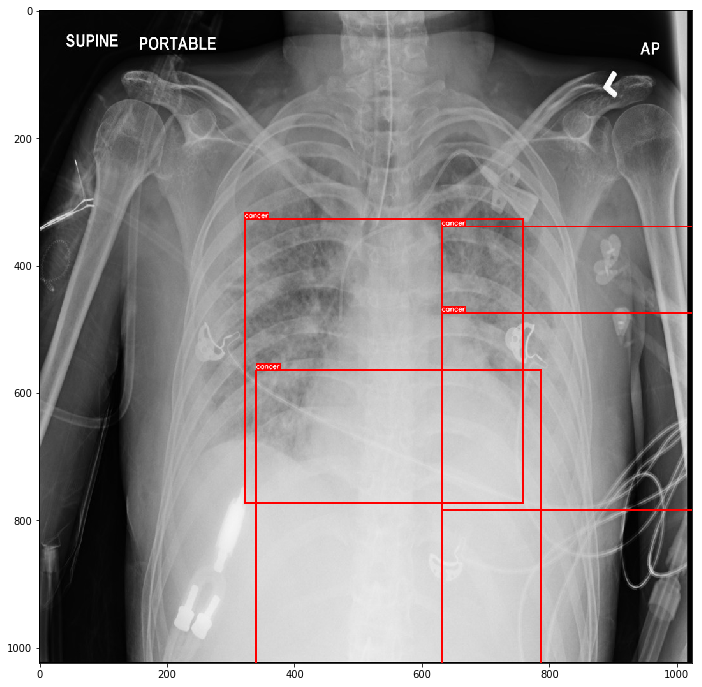

In [105]:
visualize(annotations, category_id_to_name)

In [106]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [107]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'pascal_voc', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

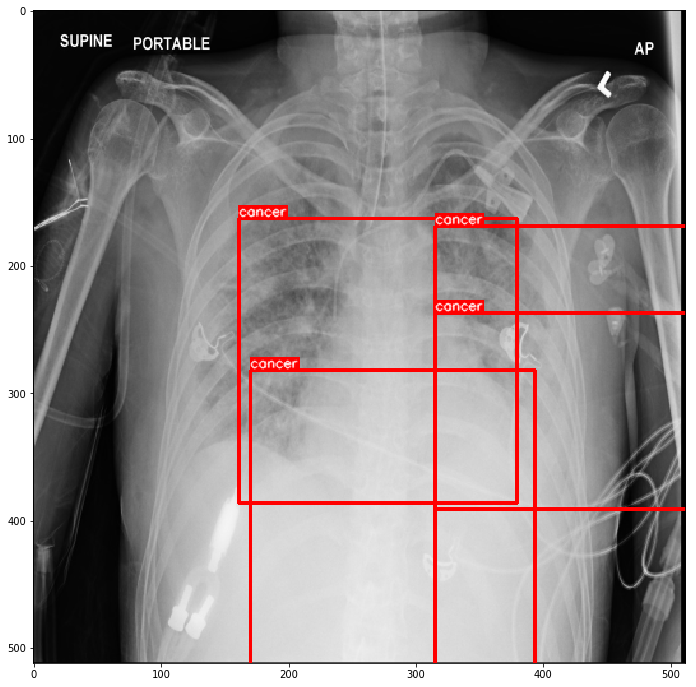

In [108]:
aug = get_aug([Resize(p=1, height=512, width=512)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

In [85]:
ti = cv2.imread('000000386298.jpg')

In [86]:
ti.shape

(375, 500, 3)

In [118]:
def load_dicom(img_id):
    image_path = os.path.join("dataset/stage_2_train_images", img_id+'.dcm')
    ds = pydicom.read_file(image_path)
    image = ds.pixel_array
    return image / 255.0

In [120]:
from tqdm import tqdm

In [122]:
avg_mean = 0
avg_std = 0
for fn in tqdm(fps):
    im = load_dicom(fn)
    avg_mean += im.mean()
    avg_std += im.std()


  9%|▉         | 2414/26684 [00:31<05:25, 74.50it/s]


 18%|█▊        | 4802/26684 [01:01<04:38, 78.49it/s]


 27%|██▋       | 7193/26684 [01:32<04:10, 77.68it/s]


 36%|███▌      | 9557/26684 [02:03<03:41, 77.39it/s]


 45%|████▍     | 11919/26684 [02:33<03:10, 77.58it/s]


 53%|█████▎    | 14254/26684 [03:04<02:42, 76.43it/s]


 62%|██████▏   | 16589/26684 [03:34<02:10, 77.28it/s]


 71%|███████   | 19002/26684 [04:05<01:37, 78.80it/s]


 80%|███████▉  | 21341/26684 [04:35<01:08, 77.97it/s]


 89%|████████▉ | 23754/26684 [05:05<00:38, 76.64it/s]


 98%|█████████▊| 26172/26684 [05:36<00:06, 77.77it/s]


100%|██████████| 26684/26684 [05:42<00:00, 77.82it/s]

In [123]:
avg_mean = avg_mean / len(fps)
avg_std = avg_std / len(fps)

In [124]:
avg_mean

0.4901120164189665

In [125]:
avg_std

0.22933109393355394

In [126]:
from models import backbone

In [128]:
model = getattr(backbone, 'se_resnext50_32x4d')(pretrained_imagenet=True)